In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.preprocessing import image

In [2]:
NUM_CLASSES = 10 

In [3]:
def build_fusion_model(input_shape=(256, 256, 3), num_classes=NUM_CLASSES):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # EfficientNet branch
    efficientnet = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_tensor=inputs
    )
    
    # Freeze early layers
    for layer in efficientnet.layers[:100]:
        layer.trainable = False
    
    # Get EfficientNet features
    x_eff = efficientnet.output
    x_eff = layers.GlobalAveragePooling2D()(x_eff)
    x_eff = layers.BatchNormalization()(x_eff)
    x_eff = layers.Dense(256, activation='relu')(x_eff)
    x_eff = layers.Dropout(0.3)(x_eff)
    
    # Simple transformer-inspired attention branch
    # Extract features using convolution with smaller patches
    x_vit = layers.Conv2D(
        filters=128,
        kernel_size=(16, 16),
        strides=(8, 8),
        padding="same"
    )(inputs)
    
    # Shape information for reshaping
    _, h, w, c = x_vit.shape
    
    # Reshape to sequence for attention
    x_vit = layers.Reshape((h * w, c))(x_vit)
    
    # Add positional embedding
    pos_embed = layers.Embedding(
        input_dim=h * w,
        output_dim=c
    )(tf.range(start=0, limit=h * w, delta=1))
    x_vit = x_vit + pos_embed
    
    # Self-attention mechanism
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    attn_output = layers.MultiHeadAttention(
        num_heads=8,
        key_dim=64
    )(x_vit, x_vit)
    x_vit = layers.Add()([attn_output, x_vit])
    
    # Second transformer block
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    attn_output = layers.MultiHeadAttention(
        num_heads=8,
        key_dim=64
    )(x_vit, x_vit)
    x_vit = layers.Add()([attn_output, x_vit])
    
    # MLP block
    x_vit = layers.LayerNormalization(epsilon=1e-6)(x_vit)
    x_vit = layers.Dense(256, activation=tf.nn.gelu)(x_vit)
    x_vit = layers.Dropout(0.1)(x_vit)
    x_vit = layers.Dense(128, activation=tf.nn.gelu)(x_vit)
    
    # Global pooling for transformer branch
    x_vit = layers.GlobalAveragePooling1D()(x_vit)
    x_vit = layers.BatchNormalization()(x_vit)
    x_vit = layers.Dense(256, activation='relu')(x_vit)
    x_vit = layers.Dropout(0.3)(x_vit)
    
    # Fusion of features
    fusion = layers.Concatenate()([x_eff, x_vit])
    fusion = layers.BatchNormalization()(fusion)
    fusion = layers.Dense(512, activation='relu')(fusion)
    fusion = layers.Dropout(0.5)(fusion)
    fusion = layers.Dense(256, activation='relu')(fusion)
    fusion = layers.Dropout(0.3)(fusion)
    
    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(fusion)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
print("Building model architecture...")
model = build_fusion_model() # Create the skeleton

print("Loading weights...")
# Note: Use load_weights, NOT load_model
model.load_weights('bone_break_cnn_model.keras') 
print("Model weights loaded successfully!")

Building model architecture...
Loading weights...
Model weights loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


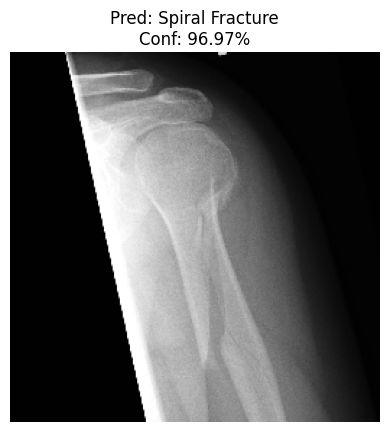

In [5]:
# --- STEP 3: Continue with Prediction ---
class_names = ["Avulsion fracture", "Comminuted fracture", "Fracture Dislocation", "Greenstick fracture", "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Oblique fracture", "Pathological fracture", "Spiral Fracture"]

def predict_bone_fracture(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    
    predictions = model.predict(img_preprocessed)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(predictions) * 100
    
    plt.imshow(img)
    plt.title(f"Pred: {predicted_class_name}\nConf: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

predict_bone_fracture("./spiral.png")